<a href="https://colab.research.google.com/github/Saibhossain/visual-Transformers_-ViT-/blob/main/Sam3_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.6 MB/s eta 0:00:00



image 1/1 /content/cat-dog.png: 448x640 2 cats, 454.4ms
Speed: 3.0ms preprocess, 454.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/cat-dog.png: 1024x1024 1 0, 1 1, 13302.9ms
Speed: 12.8ms preprocess, 13302.9ms inference, 7.9ms postprocess per image at shape (1, 3, 1024, 1024)


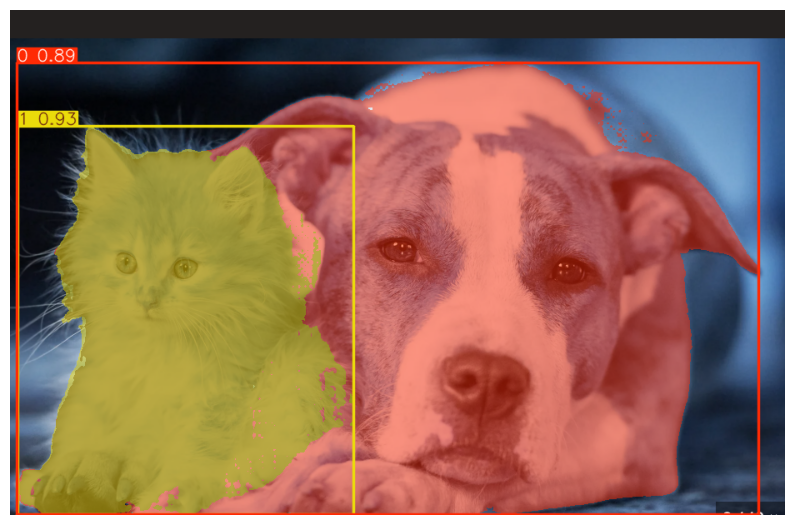

In [8]:
from ultralytics import SAM, YOLOWorld
import matplotlib.pyplot as plt
import cv2

# Load models
yolo = YOLOWorld("yolov8s-world.pt")
sam = SAM("sam2.1_b.pt")

# Settings
image_path = "/content/cat-dog.png"
prompt = "cat"

# 1. Detect with YOLO-World
yolo.set_classes([prompt])
results = yolo.predict(image_path, conf=0.1)
bboxes = results[0].boxes.xyxy.cpu().numpy()

# 2. Segment with SAM 2.1 using boxes from YOLO
if len(bboxes) > 0:
    sam_results = sam(image_path, bboxes=bboxes)

    # 3. Plot the result
    for result in sam_results:
        # Plot directly
        plt.figure(figsize=(10, 10))
        plt.imshow(result.plot()) # .plot() creates the annotated image
        plt.axis('off')
        plt.show()
else:
    print(f"No '{prompt}' found.")

Loading SAM (This may take time to download ~1GB+)...
Asking SAM to segment based on detected boxes for: 'cat'...
SAM segmented 4 instances based on detected boxes!


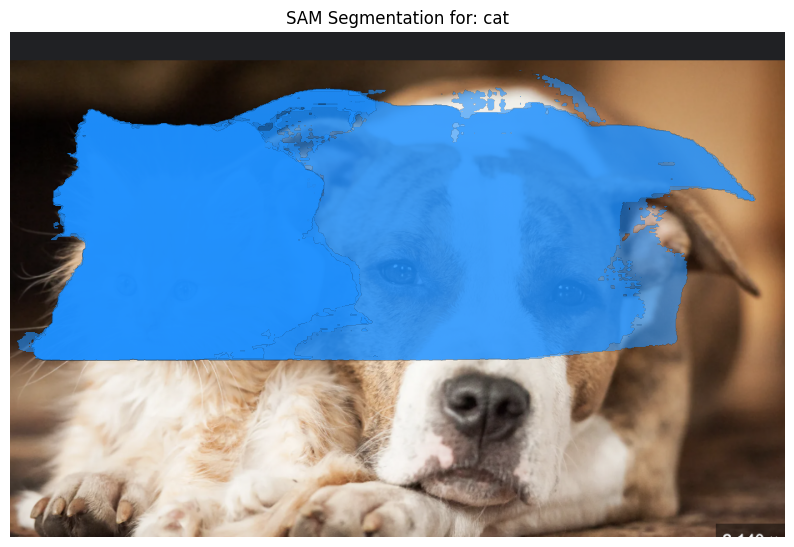

In [12]:
import torch
from PIL import Image
from transformers import AutoProcessor, SamModel
import matplotlib.pyplot as plt
import numpy as np

# =================USER CONFIGURATION=================
YOUR_IMAGE_PATH = "/content/cat-dog.png" # Changed to match image used for YOLO-World detections
TEXT_PROMPT = "cat"  # This will now be used for context, but not direct SAM input
# ====================================================

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6]) # Blueish
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def main():
    print(f"Loading SAM (This may take time to download ~1GB+)...")

    # 1. Load the Native SAM Model from Hugging Face
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
    processor = AutoProcessor.from_pretrained("facebook/sam-vit-base")

    # 2. Load Image
    image = Image.open(YOUR_IMAGE_PATH).convert("RGB")
    original_size = image.size[::-1] # (height, width)

    # Use the bboxes detected by YOLO-World from the previous cell
    # Assuming 'bboxes' variable is available in the global scope (kernel state)
    global bboxes # Access global bboxes from previous run
    if not isinstance(bboxes, np.ndarray) or bboxes.shape[0] == 0:
        print(f"No '{TEXT_PROMPT}' detections found by YOLO-World. Cannot run SAM.")
        return

    input_boxes = torch.tensor(bboxes, device=device).unsqueeze(0) # Add batch dimension

    # 3. Predict (SAM requires bounding box prompts)
    print(f"Asking SAM to segment based on detected boxes for: '{TEXT_PROMPT}'...")
    inputs = processor(images=image, input_boxes=input_boxes, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    # 4. Process Results (Manual post-processing as SamProcessor does not have post_process_instance_segmentation)
    # Get predicted masks and scores
    pred_masks = outputs.pred_masks.squeeze(0) # Shape: (num_boxes, num_masks_per_box, H, W) or (total_masks, H, W)
    iou_scores = outputs.iou_scores.squeeze(0) # Shape: (num_boxes, num_masks_per_box) or (total_masks,)

    # Flatten pred_masks and iou_scores if there are multiple masks per box
    # This handles cases where outputs.pred_masks is (1, num_boxes, num_masks_per_box, H, W)
    # after squeeze(0) -> (num_boxes, num_masks_per_box, H, W)
    if pred_masks.dim() == 4: # If shape is (num_boxes, num_masks_per_box, H, W)
        pred_masks = pred_masks.reshape(-1, pred_masks.shape[-2], pred_masks.shape[-1])
        iou_scores = iou_scores.reshape(-1) # Flatten iou_scores to match total_masks

    # Upsample masks to original image size
    upscaled_masks = torch.nn.functional.interpolate(
        pred_masks.unsqueeze(1), # Add channel dimension for interpolate (N, 1, H, W)
        size=original_size,      # Target size (original_H, original_W)
        mode="bilinear",
        align_corners=False
    ).squeeze(1) # Remove channel dimension

    # Apply sigmoid and threshold to get binary masks
    # Keep only masks with a good enough score
    filtered_masks = []
    filtered_scores = []

    # Ensure iou_scores and upscaled_masks have matching first dimension for iteration
    if upscaled_masks.shape[0] != iou_scores.shape[0]:
        print(f"Warning: Number of upscaled masks ({upscaled_masks.shape[0]}) and IOU scores ({iou_scores.shape[0]}) do not match. Proceeding with minimum.")
        num_iterations = min(upscaled_masks.shape[0], iou_scores.shape[0])
    else:
        num_iterations = upscaled_masks.shape[0]

    for i in range(num_iterations):
        mask_logits = upscaled_masks[i]
        score = iou_scores[i]
        if score > 0.8: # Example threshold for IOU score
            binary_mask = (mask_logits > 0.0).cpu().numpy() # Threshold mask logits at 0.0
            filtered_masks.append(binary_mask)
            filtered_scores.append(score.cpu().numpy())

    masks = np.array(filtered_masks)
    scores = np.array(filtered_scores)

    print(f"SAM segmented {len(masks)} instances based on detected boxes!")

    # 5. Plot Results
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    if len(masks) > 0:
        for mask, score in zip(masks, scores):
            show_mask(mask, plt.gca())
            # Optional: Print confidence score on the object
            # plt.text(10, 10, f"{score:.2f}", color="white")
    else:
        plt.text(10, 10, "No masks found with score > 0.8", color="red", backgroundcolor="white", fontsize=12)

    plt.axis('off')
    plt.title(f"SAM Segmentation for: {TEXT_PROMPT}")
    plt.show()

if __name__ == "__main__":
    main()